In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%ls ~/.kaggle/competitions/digit-recognizer/

sample_submission.csv  test.csv  train.csv


In [3]:
train = pd.read_csv('~/.kaggle/competitions/digit-recognizer/train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv('~/.kaggle/competitions/digit-recognizer/test.csv')
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


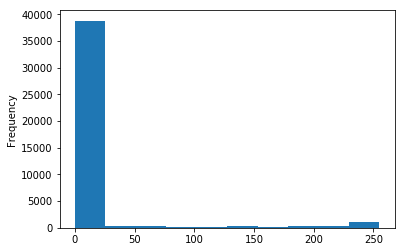

In [5]:
train.pixel100.plot(kind='hist')

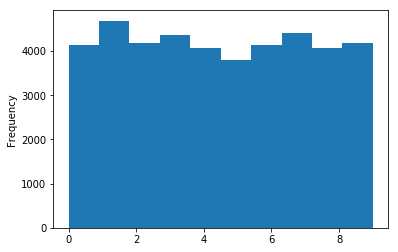

In [6]:
train.label.plot(kind='hist')

In [7]:
cols = test.columns.tolist()
len(cols)

784

In [8]:
X_train = train[cols].values / 255
y_train = train['label'].values
X_test = test[cols].values / 255

In [9]:
X_train.shape, y_train.shape

((42000, 784), (42000,))

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=768)

In [12]:
y_train.shape, y_val.shape

((37800,), (4200,))

In [13]:
np.bincount(y_train), np.bincount(y_val)

(array([3724, 4210, 3743, 3917, 3657, 3410, 3729, 3938, 3698, 3774]),
 array([408, 474, 434, 434, 415, 385, 408, 463, 365, 414]))

# Tensorflow DNN

In [14]:
y_train[:5]

array([6, 2, 0, 1, 6])

In [15]:
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## plain tensorflow

In [16]:
n_inputs = 28*28  # MNIST
n_hidden1 = 256
n_hidden2 = 64
n_outputs = 10

reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z
with tf.name_scope('dnn'):
    hidden1 = neuron_layer(X, n_hidden1, name='hidden1', activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name='hidden2', activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
learning_rate = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 128
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        for i in range(X_train.shape[0]//batch_size):
            feed_dict = {X:X_train[indices[batch_size*i:batch_size*(i+1), ]], y:y_train[indices[batch_size*i:batch_size*(i+1), ]]}
            sess.run(training_op, feed_dict=feed_dict)
        acc_train = accuracy.eval(feed_dict={X:X_train, y:y_train})
        acc_val = accuracy.eval(feed_dict={X:X_val, y:y_val})
        print('{} train_acc:{} val_acc:{}'.format(epoch, acc_train, acc_val))
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 train_acc:0.9595237970352173 val_acc:0.9526190757751465
1 train_acc:0.9534655809402466 val_acc:0.9469047784805298
2 train_acc:0.974391520023346 val_acc:0.9633333086967468
3 train_acc:0.9823809266090393 val_acc:0.9688095450401306
4 train_acc:0.9818782806396484 val_acc:0.9642857313156128
5 train_acc:0.9832539558410645 val_acc:0.9654762148857117
6 train_acc:0.988095223903656 val_acc:0.9704762101173401
7 train_acc:0.9811640381813049 val_acc:0.9661904573440552
8 train_acc:0.9817195534706116 val_acc:0.9642857313156128
9 train_acc:0.9876190423965454 val_acc:0.9685714244842529
10 train_acc:0.9858730435371399 val_acc:0.9683333039283752
11 train_acc:0.982962965965271 val_acc:0.9688095450401306
12 train_acc:0.9841799139976501 val_acc:0.9661904573440552
13 train_acc:0.9891005158424377 val_acc:0.970714271068573
14 train_acc:0.9893651008605957 val_acc:0.9702380895614624
15 train_acc:0.9883068799972534 val_acc:0.9723809361457825
16 train_acc:0.9889947175979614 val_acc:0.9671428799629211
17 train_ac

## tf.layers.dense()

In [18]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
learning_rate = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [19]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 128
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        for i in range(X_train.shape[0]//batch_size):
            feed_dict = {X:X_train[indices[batch_size*i:batch_size*(i+1), ]], y:y_train[indices[batch_size*i:batch_size*(i+1), ]]}
            sess.run(training_op, feed_dict=feed_dict)
        acc_train = accuracy.eval(feed_dict={X:X_train, y:y_train})
        acc_val = accuracy.eval(feed_dict={X:X_val, y:y_val})
        print('{} train_acc:{} val_acc:{}'.format(epoch, acc_train, acc_val))
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 train_acc:0.9619576930999756 val_acc:0.954285740852356
1 train_acc:0.9697089791297913 val_acc:0.9571428298950195
2 train_acc:0.9766930937767029 val_acc:0.9676190614700317
3 train_acc:0.9774073958396912 val_acc:0.9635714292526245
4 train_acc:0.9790211915969849 val_acc:0.9607142806053162
5 train_acc:0.9795502424240112 val_acc:0.9657142758369446
6 train_acc:0.983042299747467 val_acc:0.9690476059913635
7 train_acc:0.9864020943641663 val_acc:0.9704762101173401
8 train_acc:0.9907671809196472 val_acc:0.9721428751945496
9 train_acc:0.9846296310424805 val_acc:0.9642857313156128
10 train_acc:0.9857936501502991 val_acc:0.9678571224212646
11 train_acc:0.9850793480873108 val_acc:0.9695237874984741
12 train_acc:0.9875132441520691 val_acc:0.9704762101173401
13 train_acc:0.9896296262741089 val_acc:0.967380940914154
14 train_acc:0.9886507987976074 val_acc:0.9690476059913635
15 train_acc:0.9866666793823242 val_acc:0.9635714292526245
16 train_acc:0.9926190376281738 val_acc:0.9735714197158813
17 train_a

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    Z = logits.eval(feed_dict={X:X_val})
    y_pred = np.argmax(Z, axis=1)
y_pred[:20], y_val[:20]

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


(array([6, 3, 1, 3, 1, 5, 1, 5, 9, 0, 1, 5, 8, 2, 1, 9, 9, 6, 3, 4]),
 array([6, 3, 1, 3, 1, 5, 1, 5, 9, 0, 1, 5, 8, 2, 1, 9, 9, 6, 3, 4]))

In [21]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    Z = logits.eval(feed_dict={X:X_test})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [22]:
df_submit = pd.DataFrame(y_pred, columns=['Label'])
df_submit.index += 1
df_submit.index.name = 'ImageId'
df_submit.to_csv('~/projects/kaggle/digit_recognizer/submit.csv', index=True)